In [ ]:
!pip install stopwords

import stopwords

import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [ ]:
train, test = tfds.load("imdb_reviews", split=["train", "test"], as_supervised=True)

In [3]:
unlist = stopwords.get_stopwords("english")

type(unlist)

list

In [4]:
train_input = []; train_label = []

test_input = []; test_label = []

retori = lambda snt : [i for i in snt.lower().split() if i not in unlist]

for data, label in train:
  retari = " ".join(retori(data.numpy().decode("utf8")))
  train_input.append(retari)
  train_label.append(label.numpy())

for data, label in test:
  retari = " ".join(retori(data.numpy().decode("utf8")))
  test_input.append(retari)
  test_label.append(label.numpy())

In [5]:
len(train_input), len(test_input), len(train_label), len(test_label)

(25000, 25000, 25000, 25000)

In [6]:
import tensorflow.keras.layers as layers

vector = layers.TextVectorization(max_tokens=10)

sample = ["aku suka ikan", "ikan goreng", "ibu masak ikan", "bapak masak ayam bersama ibu"]

vector.adapt(sample)

In [7]:
vector.get_vocabulary()[:5]

['', '[UNK]', 'ikan', 'masak', 'ibu']

In [8]:
vector.get_vocabulary()[5:]

['suka', 'goreng', 'bersama', 'bapak', 'ayam']

In [9]:
vector.get_vocabulary()[1]

'[UNK]'

In [10]:
samplet = ["ikan masak ibu tadi"]

vector(samplet).numpy()

array([[2, 3, 4, 1]])

In [11]:
vector.get_vocabulary(include_special_tokens=False)

['ikan', 'masak', 'ibu', 'suka', 'goreng', 'bersama', 'bapak', 'ayam']

In [12]:
len(vector.get_vocabulary())

10

In [13]:
max_tokens = 15000

embedding = 16

output_sequence_length = 180

tokener = layers.TextVectorization(
  max_tokens=max_tokens, output_mode="int",
  pad_to_max_tokens=True,
  output_sequence_length=output_sequence_length)

tokener.adapt(train_input)

In [14]:
len(tokener.get_vocabulary())

15000

In [15]:
import numpy as np

train_input = np.array(tokener(train_input))

train_label = np.array(train_label)

In [16]:
len(train_input), len(train_label)

(25000, 25000)

In [17]:
train_input[0][:5]

array([  318,   292,     3, 10671,  1244])

In [18]:
test_input = np.array(tokener(test_input))

test_label = np.array(test_label)

In [19]:
inputs = tf.keras.layers.Input(shape=(output_sequence_length,))

embedding = tf.keras.layers.Embedding(max_tokens,embedding)(inputs)

droupout = tf.keras.layers.Dropout(0.2)(embedding)

pooling = tf.keras.layers.GlobalAveragePooling1D()(droupout)

droupout = tf.keras.layers.Dropout(0.2)(pooling)

output = tf.keras.layers.Dense(1, activation='sigmoid')(droupout)

model = tf.keras.Model(inputs=inputs, outputs=output)

In [20]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
plot = model.fit(train_input, train_label, epochs=10, validation_data=(test_input, test_label))

In [22]:
model.evaluate(train_input, train_label, verbose=0)

[0.1617421805858612, 0.9460399746894836]

In [23]:
model.evaluate(test_input, test_label, verbose=0)

[0.3069874346256256, 0.8759599924087524]

In [24]:
import Helplot, os

plot = Helplot.Helplot(plot)

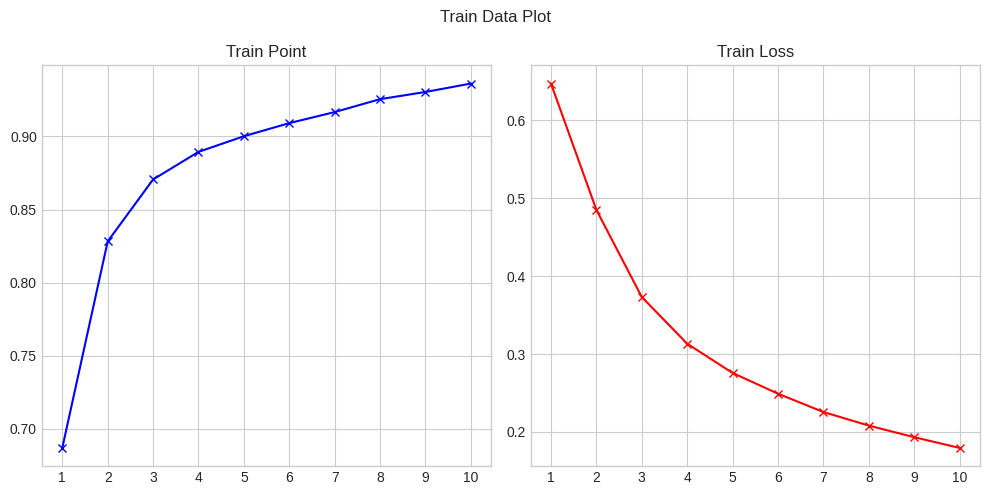

In [25]:
plot.trainplot

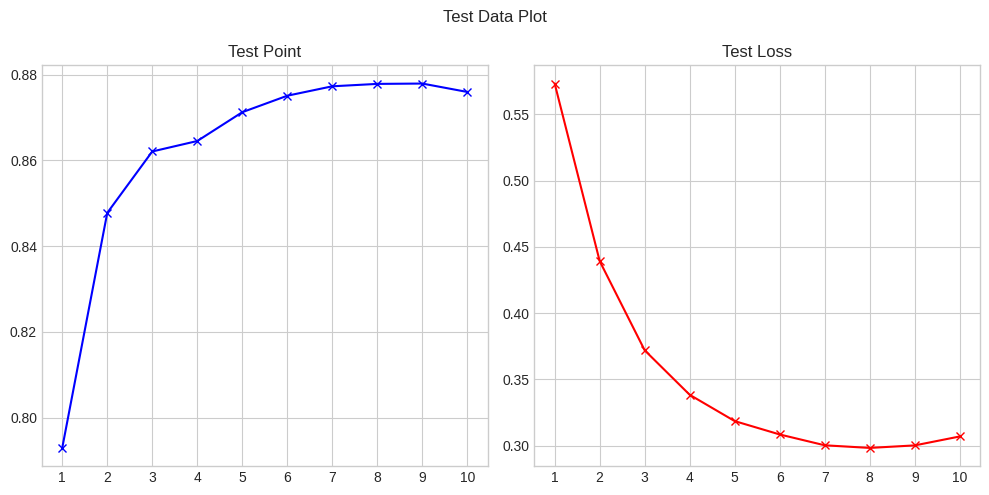

In [26]:
plot.testiplot

In [ ]:
import os

model.save("/content/model.h5")

In [ ]:
!pip install apache_beam[gcp] --quiet

import warnings

import apache_beam as beam

warnings.filterwarnings("ignore")

In [29]:
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerTensor

from apache_beam.ml.inference.base import RunInference

tensor = TFModelHandlerTensor("/content/model.h5", compile=False)

In [30]:
trainer = train_input[:10]

len(trainer)

10

In [31]:
labeler = lambda result : result.inference.numpy()[0].round()

In [ ]:
with beam.Pipeline() as pipeline:
  runner = (
    pipeline
    | 'Create' >> beam.Create(trainer)
    | 'RunInference' >> RunInference(tensor)
    | 'Outer' >> beam.Map(labeler)
    | 'Unlist' >> beam.combiners.ToList()
    | 'Output' >> beam.io.WriteToText("/content/result.txt")
  )

In [33]:
!cat /content/result.txt-00000-of-00001

[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
